# 1.Install and Import Dependancies

In [1]:
!pip install tensorflow==2.13 opencv-python mediapipe scikit-learn matplotlib

In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mp_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Colour Conversion BGR to RGB
    image.flags.writeable = False # Image no longer writeable
    results = model.process(image) # Making prediction
    image.flags.writeable = True # Image now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Colour Conversion RGB to BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    # Draws face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draws pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draws left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draws right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #Reading feed
        ret,frame = cap.read()
        
        #Making Detections
        image,results = mp_detection(frame,holistic)
        print(results)
        
        #Draw Landmarks
        draw_landmarks(image, results)
        
        #Showing Frame
        cv2.imshow('OpenCV Feed', image)
        
        #To exit
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
cap.release()
cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined

In [7]:
len(results.left_hand_landmarks.landmark)

21

In [8]:
results

mediapipe.python.solution_base.SolutionOutputs

In [9]:
draw_landmarks(frame, results)

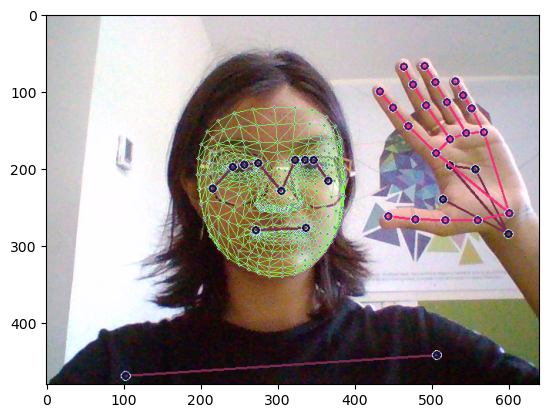

In [10]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [11]:
len(results.pose_landmarks.landmark)

33

In [12]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x,res.y,res.z,res.visibility])
    pose.append(test)

In [13]:
#Converting to numpy arrays and error handling

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
result_test = extract_keypoints(results)
result_test

array([ 0.4771553,  0.4785009, -1.4215523, ...,  0.       ,  0.       ,
        0.       ])

In [15]:
np.save('0', result_test)

In [16]:
np.load('0.npy')

array([ 0.4771553,  0.4785009, -1.4215523, ...,  0.       ,  0.       ,
        0.       ])

# 4. Setup Folders for Collection

In [17]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'yes', 'no', 'friend', 'iloveyou'])

# 30 videos 
num_sequences = 30

# Videos will be 30 frames in length
sequence_length = 30

In [18]:
for action in actions: 
    for sequence in range(num_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [19]:
#Saving the frames as numpy arrays

In [20]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(num_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mp_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_landmarks(image, results)
                
                # Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_COMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6.Preprocess Data and Create Labels and Features

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [22]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'yes': 2, 'no': 3, 'friend': 4, 'iloveyou': 5}

In [23]:
#Labelling each video
sequences, labels = [], []
for action in actions:
    for sequence in range(num_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [24]:
np.array(labels).shape

(180,)

In [25]:
X = np.array(sequences)
X.shape

(180, 30, 1662)

In [26]:
y = to_categorical(labels).astype(int)

In [27]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [29]:
X_test.shape

(9, 30, 1662)

In [30]:
y_test.shape

(9, 6)

# 7.Build and Train an LSTM Neural Network

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [32]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [33]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [34]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [37]:
model.fit(X_train, y_train, epochs=70, callbacks=[tb_callback])

Epoch 1/70
6/6 [==============================] - 1s 104ms/step - loss: 1.7911 - categorical_accuracy: 0.1754
Epoch 2/70
6/6 [==============================] - 1s 104ms/step - loss: 1.7911 - categorical_accuracy: 0.1754
Epoch 3/70
6/6 [==============================] - 1s 101ms/step - loss: 1.7911 - categorical_accuracy: 0.1754
Epoch 4/70
6/6 [==============================] - 0s 76ms/step - loss: 1.7911 - categorical_accuracy: 0.1754
Epoch 5/70
6/6 [==============================] - 0s 75ms/step - loss: 1.7911 - categorical_accuracy: 0.1754
Epoch 6/70
6/6 [==============================] - 0s 76ms/step - loss: 1.7911 - categorical_accuracy: 0.1754
Epoch 7/70
6/6 [==============================] - 0s 75ms/step - loss: 1.7910 - categorical_accuracy: 0.1754
Epoch 8/70
6/6 [==============================] - 0s 75ms/step - loss: 1.7911 - categorical_accuracy: 0.1754
Epoch 9/70
6/6 [==============================] - 0s 75ms/step - loss: 1.7911 - categorical_accuracy: 0.1754
Epoch 10/70
6/6 

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 596774 (2.28 MB)
Trainable params: 596774 

# 8.Making Predictions

In [39]:
res = model.predict(X_test)

1/1 [==============================] - 0s 351ms/step


In [40]:
actions[np.argmax(res[4])]

'thanks'

In [41]:
actions[np.argmax(y_test[4])]

'iloveyou'

# 9.Saving Weights

In [42]:
model.save('action.h5')

C:\Users\anika\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 10.Evaluation using Confusion Matrix and Accuracy

In [43]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [44]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 37ms/step


In [45]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [46]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[8., 0.],
        [1., 0.]],

       [[0., 9.],
        [0., 0.]],

       [[7., 0.],
        [2., 0.]],

       [[6., 0.],
        [3., 0.]],

       [[6., 0.],
        [3., 0.]]])

In [47]:
accuracy_score(ytrue, yhat)

0.0

# 11.Testing

In [50]:
from scipy import stats

In [51]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [8]:
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mp_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
          # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined

In [7]:
cap.release()
cv2.destroyAllWindows()